In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy import stats
#from scipy.stats import linregress
from pprint import pprint
import calendar
from calendar import month_abbr
import datetime as dt
import matplotlib.dates as mdates

In [2]:
Weather_Path = "Clean Data/SAWeatherAll.csv"
Drought_Path = "Clean Data/dm_export_20160705_20220705.csv"
J17_Well_Path = "Clean Data/j17.csv"


Weather_Data_df = pd.read_csv(Weather_Path, encoding="utf-8")
Drought_Data_df = pd.read_csv(Drought_Path, encoding="utf-8")
J17_Well_Data_df = pd.read_csv(J17_Well_Path, encoding="utf-8")

In [3]:
Weather_Data_df

,Unnamed: 0,Month,Day,Year,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation
0,0,Jan,1,2016,49,46.3,44,73,61.5,51,0.00
1,1,Jan,2,2016,48,45.0,43,93,67.2,48,0.00
2,2,Jan,3,2016,61,47.7,35,96,75.6,49,0.22
3,3,Jan,4,2016,57,42.7,33,93,67.6,37,0.00
4,4,Jan,5,2016,57,44.9,30,96,74.4,55,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2398,207,Jul,27,2022,101,86.5,74,93,61.2,28,0.00
2399,208,Jul,28,2022,100,86.2,76,94,63.1,31,0.00
2400,209,Jul,29,2022,100,86.8,76,94,63.0,31,0.00
2401,210,Jul,30,2022,100,87.6,73,96,56.7,27,0.00


In [4]:
#only run this ONCE you will get an error if you dont restart the kernel
#changes the months in month_abbr to lower case
lower_ma = [m.lower() for m in month_abbr]

#changes the months in df to lowercase and maps the values to numerical months
Weather_Data_df['Month'] = Weather_Data_df['Month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')


In [5]:
#uses the apply method to merge our numerical month values into one column
cols=["Month", "Day", "Year"]
Weather_Data_df['Date'] = Weather_Data_df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")

Weather_Data_df = Weather_Data_df.drop(columns = ["Month", "Day", "Year", "Unnamed: 0"])

Weather_Data_df["Date"] = pd.to_datetime(Weather_Data_df["Date"])

In [6]:
Weather_Data_df.dtypes

Temp Max                  int64
Temp Avg                float64
Temp Min                  int64
Humidity Max              int64
Humidity Avg            float64
Humidity Min              int64
Precipitation           float64
Date             datetime64[ns]
dtype: object

In [7]:
#we only need to filter for last 5 years
# double check and ensure its J17 only
#clean it 

J17_Well_Data_df = J17_Well_Data_df.dropna()
J17_Well_Data_df

,Site,DailyHighDate,WaterLevelElevation
0,J17WL,7/5/2022,635.98
1,J17WL,7/4/2022,636.85
2,J17WL,7/3/2022,637.15
3,J17WL,7/2/2022,636.71
4,J17WL,7/1/2022,636.55
...,...,...,...
2373,J17WL,1/5/2016,667.55
2374,J17WL,1/4/2016,667.70
2375,J17WL,1/3/2016,666.69
2376,J17WL,1/2/2016,666.37


In [8]:
J17_Well_Data_df = J17_Well_Data_df.dropna()
J17_Well_Data_df["DailyHighDate"]= pd.to_datetime(J17_Well_Data_df["DailyHighDate"])
J17_Well_Data_df.dtypes

Site                           object
DailyHighDate          datetime64[ns]
WaterLevelElevation           float64
dtype: object

In [9]:
#create bins for aquifer water level
waterlevel = [0, 639, 649, 659, 700]

# Create the names for what restriction the city will be placed under based on water level
restriction = ["restriction 3", "restriction 2", "restriction 1", "no restriction"]

#create a new column for restriction level, we can filter based off these later
J17_Well_Data_df["Restriction Level"] = pd.cut(J17_Well_Data_df["WaterLevelElevation"], waterlevel, labels=restriction)

In [10]:
J17_Well_Data_df

,Site,DailyHighDate,WaterLevelElevation,Restriction Level
0,J17WL,2022-07-05,635.98,restriction 3
1,J17WL,2022-07-04,636.85,restriction 3
2,J17WL,2022-07-03,637.15,restriction 3
3,J17WL,2022-07-02,636.71,restriction 3
4,J17WL,2022-07-01,636.55,restriction 3
...,...,...,...,...
2373,J17WL,2016-01-05,667.55,no restriction
2374,J17WL,2016-01-04,667.70,no restriction
2375,J17WL,2016-01-03,666.69,no restriction
2376,J17WL,2016-01-02,666.37,no restriction


In [11]:
#Change to datetime
Drought_Data_df[['ValidStart','ValidEnd']] = Drought_Data_df[['ValidStart','ValidEnd']].apply(pd.to_datetime)
Drought_Data_df.dtypes

MapDate                       int64
FIPS                          int64
County                       object
State                        object
None                        float64
D0                          float64
D1                          float64
D2                          float64
D3                          float64
D4                          float64
ValidStart           datetime64[ns]
ValidEnd             datetime64[ns]
StatisticFormatID             int64
dtype: object

In [12]:
Drought_Data_df

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20220705,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,27.38,2022-07-05,2022-07-11,1
1,20220628,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-28,2022-07-04,1
2,20220621,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-21,2022-06-27,1
3,20220614,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,49.45,2022-06-14,2022-06-20,1
4,20220607,48029,Bexar County,TX,0.0,100.0,100.0,100.0,100.0,10.40,2022-06-07,2022-06-13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,20160802,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-08-02,2016-08-08,1
310,20160726,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-26,2016-08-01,1
311,20160719,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-19,2016-07-25,1
312,20160712,48029,Bexar County,TX,100.0,0.0,0.0,0.0,0.0,0.00,2016-07-12,2016-07-18,1


# Filtering Data

In [13]:
#for aquifer data the most recent date we have is 2022-07-05, filter accordingly to get 5 yrs worth of data
#we do this for all 3 data sets we have
Weather_Data_2016_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2016-07-05") & (Weather_Data_df["Date"] <= "2016-12-31")]
Weather_Data_2017_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2017-01-01") & (Weather_Data_df["Date"] <= "2017-12-31")]
Weather_Data_2018_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2018-01-01") & (Weather_Data_df["Date"] <= "2018-12-31")]
Weather_Data_2019_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2019-01-01") & (Weather_Data_df["Date"] <= "2019-12-31")]
Weather_Data_2020_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2020-01-01") & (Weather_Data_df["Date"] <= "2020-12-31")]
Weather_Data_2021_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2021-01-01") & (Weather_Data_df["Date"] <= "2021-12-31")]
Weather_Data_2022_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2022-01-01") & (Weather_Data_df["Date"] <= "2022-07-05")]

In [14]:
J17_2016_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2016-07-05") & (J17_Well_Data_df["DailyHighDate"] <= "2016-12-31")]
J17_2017_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2017-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2017-12-31")]
J17_2018_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2018-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2018-12-31")]
J17_2019_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2019-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2019-12-31")]
J17_2020_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2020-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2020-12-31")]
J17_2021_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2021-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2021-12-31")]
J17_2022_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2022-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2022-07-05")]


In [15]:
Drought_Data_2016_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2016-07-05") & (Drought_Data_df["ValidEnd"] <= "2016-12-31")]
Drought_Data_2017_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2017-01-01") & (Drought_Data_df["ValidEnd"] <= "2017-12-31")]
Drought_Data_2018_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2018-01-01") & (Drought_Data_df["ValidEnd"] <= "2018-12-31")]
Drought_Data_2019_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2019-01-01") & (Drought_Data_df["ValidEnd"] <= "2019-12-31")]
Drought_Data_2020_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2020-01-01") & (Drought_Data_df["ValidEnd"] <= "2020-12-31")]
Drought_Data_2021_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2021-01-01") & (Drought_Data_df["ValidEnd"] <= "2021-12-31")]
Drought_Data_2022_df = Drought_Data_df.loc[(Drought_Data_df["ValidStart"] >= "2022-01-01") & (Drought_Data_df["ValidEnd"] <= "2022-12-31")]

In [16]:
Weather_Data_df

,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation,Date
0,49,46.3,44,73,61.5,51,0.00,2016-01-01
1,48,45.0,43,93,67.2,48,0.00,2016-01-02
2,61,47.7,35,96,75.6,49,0.22,2016-01-03
3,57,42.7,33,93,67.6,37,0.00,2016-01-04
4,57,44.9,30,96,74.4,55,0.00,2016-01-05
...,...,...,...,...,...,...,...,...
2398,101,86.5,74,93,61.2,28,0.00,2022-07-27
2399,100,86.2,76,94,63.1,31,0.00,2022-07-28
2400,100,86.8,76,94,63.0,31,0.00,2022-07-29
2401,100,87.6,73,96,56.7,27,0.00,2022-07-30


In [17]:
#get only desired columns from weather data
weather_short = Weather_Data_df[['Date', 'Temp Max','Precipitation']].copy()

#merging weather (temps) with water elevation data
Weather_Restriction_df=J17_Well_Data_df.merge(weather_short[['Date', 'Temp Max','Precipitation']], right_on="Date",left_on="DailyHighDate")
#keeping only desired columns
Weather_Restriction_df=Weather_Restriction_df[['Date', 'Temp Max','WaterLevelElevation','Restriction Level','Precipitation']].copy()
Weather_Restriction_df['year'] = pd.DatetimeIndex(Weather_Restriction_df['Date']).year
Weather_Restriction_df

,Date,Temp Max,WaterLevelElevation,Restriction Level,Precipitation,year
0,2022-07-05,99,635.98,restriction 3,0.00,2022
1,2022-07-04,99,636.85,restriction 3,0.00,2022
2,2022-07-03,99,637.15,restriction 3,0.00,2022
3,2022-07-02,99,636.71,restriction 3,0.00,2022
4,2022-07-01,93,636.55,restriction 3,0.00,2022
...,...,...,...,...,...,...
2372,2016-01-05,57,667.55,no restriction,0.00,2016
2373,2016-01-04,57,667.70,no restriction,0.00,2016
2374,2016-01-03,61,666.69,no restriction,0.22,2016
2375,2016-01-02,48,666.37,no restriction,0.00,2016


In [60]:
#J17_Well_Data_df
J17_Well_Data_Total_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2016-07-05") & (J17_Well_Data_df["DailyHighDate"] <= "2022-07-05")]
J17_Well_Final_Data = J17_Well_Data_Total_df.loc[(J17_Well_Data_df["DailyHighDate"] != "2020-11-08")]
J17_Well_Final_Data

,Site,DailyHighDate,WaterLevelElevation,Restriction Level
0,J17WL,2022-07-05,635.98,restriction 3
1,J17WL,2022-07-04,636.85,restriction 3
2,J17WL,2022-07-03,637.15,restriction 3
3,J17WL,2022-07-02,636.71,restriction 3
4,J17WL,2022-07-01,636.55,restriction 3
...,...,...,...,...
2187,J17WL,2016-07-09,670.67,no restriction
2188,J17WL,2016-07-08,671.13,no restriction
2189,J17WL,2016-07-07,671.84,no restriction
2190,J17WL,2016-07-06,672.72,no restriction


In [61]:
#weather Data fixed
Weather_Data_Temp_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2016-07-05") & (Weather_Data_df["Date"] <= "2022-07-05")]

Weather_Data_Temp_df.loc[(Weather_Data_df["Date"] != "2020-11-08")]
Weather_Data_Temp_df

,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation,Date
186,98,86.0,79,90,70.3,43,0.0,2016-07-05
187,98,85.2,79,90,70.6,41,0.0,2016-07-06
188,98,85.2,78,90,70.1,42,0.0,2016-07-07
189,98,86.1,79,88,67.0,39,0.0,2016-07-08
190,98,85.5,77,96,70.2,39,0.0,2016-07-09
...,...,...,...,...,...,...,...,...
2372,93,83.3,72,93,66.7,42,0.0,2022-07-01
2373,99,86.5,77,96,65.0,32,0.0,2022-07-02
2374,99,86.8,77,94,62.7,30,0.0,2022-07-03
2375,99,84.6,75,96,67.7,33,0.0,2022-07-04


In [20]:
#Drought_well_merge = pd.concat([J17_merge_df, ])
mask = Drought_Data_df.loc[(Drought_Data_df['ValidStart'].dt.month == int(7))]#.mean()
mask

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20220705,48029,Bexar County,TX,0.00,100.00,100.00,100.00,100.0,27.38,2022-07-05,2022-07-11,1
49,20210727,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-27,2021-08-02,1
50,20210720,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-20,2021-07-26,1
51,20210713,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-13,2021-07-19,1
52,20210706,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2021-07-06,2021-07-12,1
101,20200728,48029,Bexar County,TX,14.89,85.11,0.00,0.00,0.0,0.00,2020-07-28,2020-08-03,1
102,20200721,48029,Bexar County,TX,0.00,100.00,0.00,0.00,0.0,0.00,2020-07-21,2020-07-27,1
103,20200714,48029,Bexar County,TX,0.00,100.00,0.00,0.00,0.0,0.00,2020-07-14,2020-07-20,1
104,20200707,48029,Bexar County,TX,0.45,99.55,0.00,0.00,0.0,0.00,2020-07-07,2020-07-13,1
153,20190730,48029,Bexar County,TX,100.00,0.00,0.00,0.00,0.0,0.00,2019-07-30,2019-08-05,1


Text(0, 0.5, 'Water Level')

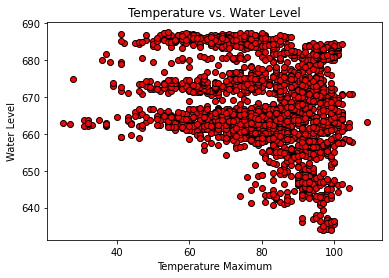

In [62]:
#
#Plot a bar chart using Temperature vs Water level to show correlation
Scatter_temp_merge = Weather_Data_Temp_df['Temp Max']
Scatter_waterlvl_merge = J17_Well_Final_Data['WaterLevelElevation']
plt.scatter(Scatter_temp_merge, Scatter_waterlvl_merge, marker="o", facecolors="red", edgecolors="black")
plt.title("Temperature vs. Water Level")
plt.xlabel("Temperature Maximum")
plt.ylabel("Water Level")
#explorepossible analysis

In [22]:
Weather_Data_Perc_df = Weather_Data_df.loc[(Weather_Data_df["Date"] >= "2016-07-05") & (Weather_Data_df["Date"] <= "2022-07-05")]

Weather_Data_Perc_df.loc[(Weather_Data_df["Date"] != "2020-2-25") & (Weather_Data_df["Date"] != "2020-2-26") & (Weather_Data_df["Date"] != "2020-2-27") & (Weather_Data_df["Date"] != "2020-2-28") & (Weather_Data_df["Date"] != "2020-2-29")]
Weather_Data_Perc_df

,Temp Max,Temp Avg,Temp Min,Humidity Max,Humidity Avg,Humidity Min,Precipitation,Date
186,98,86.0,79,90,70.3,43,0.0,2016-07-05
187,98,85.2,79,90,70.6,41,0.0,2016-07-06
188,98,85.2,78,90,70.1,42,0.0,2016-07-07
189,98,86.1,79,88,67.0,39,0.0,2016-07-08
190,98,85.5,77,96,70.2,39,0.0,2016-07-09
...,...,...,...,...,...,...,...,...
2372,93,83.3,72,93,66.7,42,0.0,2022-07-01
2373,99,86.5,77,96,65.0,32,0.0,2022-07-02
2374,99,86.8,77,94,62.7,30,0.0,2022-07-03
2375,99,84.6,75,96,67.7,33,0.0,2022-07-04


Text(0, 0.5, 'Water Level')

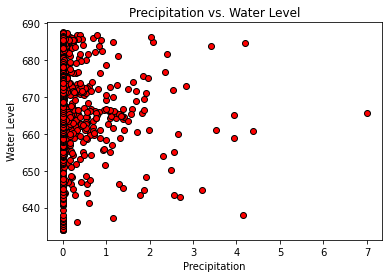

In [23]:
#
#Plot a bar chart using Temperature vs Water level to show correlation
Scatter_temp_merge = Weather_Data_Perc_df['Precipitation']
Scatter_waterlvl_merge = J17_Well_Final_Data['WaterLevelElevation']
plt.scatter(Scatter_temp_merge, Scatter_waterlvl_merge, marker="o", facecolors="red", edgecolors="black")
plt.title("Precipitation vs. Water Level")
plt.xlabel("Precipitation")
plt.ylabel("Water Level")
#explorepossible analysis

     DailyHighDate Restriction Level
0       2022-07-05     restriction 3
1       2022-07-04     restriction 3
2       2022-07-03     restriction 3
3       2022-07-02     restriction 3
4       2022-07-01     restriction 3
...            ...               ...
2187    2016-07-09    no restriction
2188    2016-07-08    no restriction
2189    2016-07-07    no restriction
2190    2016-07-06    no restriction
2191    2016-07-05    no restriction

[2191 rows x 2 columns]


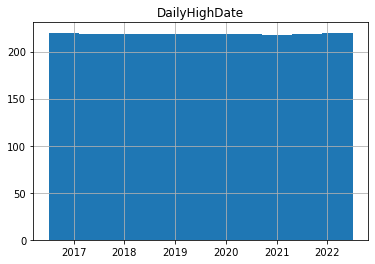

In [24]:
##WORK IN PROGRESS HERE
#Histogram of restriction counts
water_elevation=J17_Well_Final_Data[['DailyHighDate', 'Restriction Level']].copy()

  
# displaying the DataFrame
print(water_elevation)
  
# creating a basic histogram
water_elevation.hist()
plt.show()

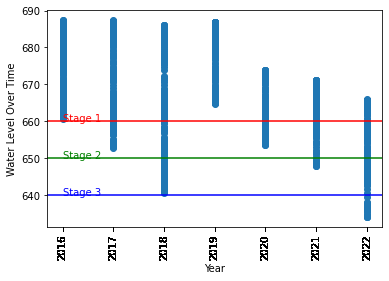

In [25]:
#here is where I was going to put a side by side of water level over time and temp over time
# Generate a scatter plot of year versus water level over time
#Weather_Restriction_df
year = Weather_Restriction_df.iloc[:,5]

waterlevel = Weather_Restriction_df.iloc[:,2]
plt.scatter(year,waterlevel)
plt.xticks(year, rotation=90)
stage1=plt.axhline(y=660, color='r', linestyle='-',label="Stage 1")
stage2=plt.axhline(y=650, color='g', linestyle='-',label='Drought 2')
stage3=plt.axhline(y=640, color='b', linestyle='-',label='Drought 3+')
plt.annotate("Stage 1",(2016,660),fontsize=10,color='red')
plt.annotate("Stage 2",(2016,650),fontsize=10,color='green')
plt.annotate("Stage 3",(2016,640),fontsize=10,color='blue')
plt.xlabel('Year')
plt.ylabel('Water Level Over Time')
plt.show()
#Note here we can see the over time that the water level is not being replenished as quickly as we are using it

In [26]:
Weather_Restriction_df

,Date,Temp Max,WaterLevelElevation,Restriction Level,Precipitation,year
0,2022-07-05,99,635.98,restriction 3,0.00,2022
1,2022-07-04,99,636.85,restriction 3,0.00,2022
2,2022-07-03,99,637.15,restriction 3,0.00,2022
3,2022-07-02,99,636.71,restriction 3,0.00,2022
4,2022-07-01,93,636.55,restriction 3,0.00,2022
...,...,...,...,...,...,...
2372,2016-01-05,57,667.55,no restriction,0.00,2016
2373,2016-01-04,57,667.70,no restriction,0.00,2016
2374,2016-01-03,61,666.69,no restriction,0.22,2016
2375,2016-01-02,48,666.37,no restriction,0.00,2016


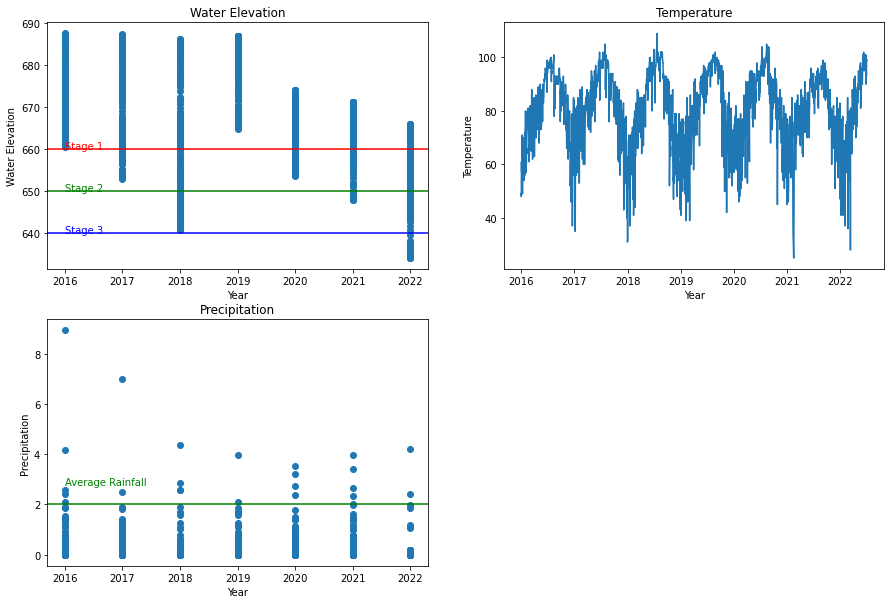

In [27]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
year = Weather_Restriction_df.iloc[:,5]
waterlevel = Weather_Restriction_df.iloc[:,2]
ax1.scatter(year,waterlevel)
stage1=ax1.axhline(y=660, color='r', linestyle='-',label='Stage 1')
stage2=ax1.axhline(y=650, color='g', linestyle='-',label='Stage 2')
stage3=ax1.axhline(y=640, color='b', linestyle='-',label='Stage 3+')
ax1.annotate("Stage 1",(2016,660),fontsize=10,color='red')
ax1.annotate("Stage 2",(2016,650),fontsize=10,color='green')
ax1.annotate("Stage 3",(2016,640),fontsize=10,color='blue')

ax1.set_title('Water Elevation')
ax1.set_xlabel('Year')
ax1.set_ylabel('Water Elevation')



ax2 = fig.add_subplot(2,2,2)
ax2.plot(Weather_Restriction_df["Date"],Weather_Restriction_df["Temp Max"])
ax2.set_title('Temperature')
ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature')


year = Weather_Restriction_df.iloc[:,5]
precipitation = Weather_Restriction_df.iloc[:,4]
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(year,precipitation)
ax3.set_title('Precipitation')
ax3.set_xlabel('Year')
ax3.set_ylabel('Precipitation')
stage3=ax3.axhline(y=2, color='g', linestyle='-',label='Stage 3+')
ax3.annotate("Average Rainfall",(2016,2.75),fontsize=10,color='green')
plt.show()
#here we can see something happened to the water level in 2020 and it never rebounded from the 670 level
#looking at the end of 2022- the drop is considerable?
#check temps to see if we had consistent high temps to explain this dip, but regular seasonal patterns can be seen.
#When looking at the scatter plot version of precip- noted sparser plots in 2022 than in previous years
#conclusion is outside factors contributed heavily to the noticeable drop in 2020 in the water elevation

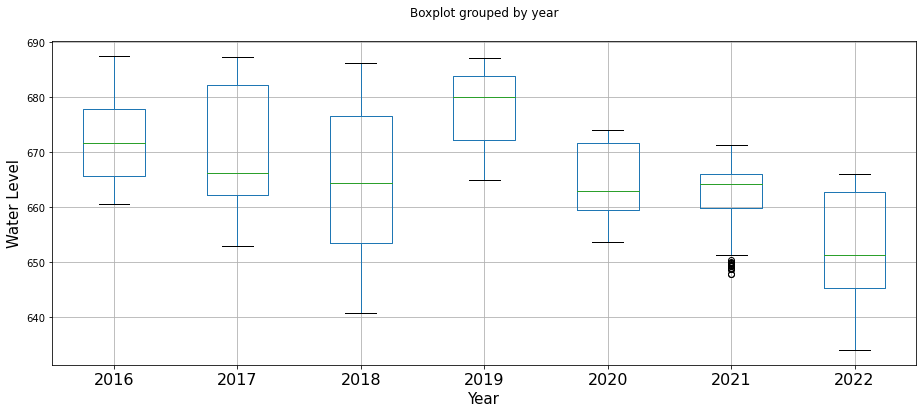

In [28]:
Weather_Restriction_df.boxplot(['WaterLevelElevation'], ['year'], figsize = (15,6))
plt.title("", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Water Level", fontsize=15)
plt.xticks(fontsize = 16)
plt.show()

In [30]:
#do a linregress for max temp and water level
#use the cleaned data so they will be the same size, it will not work if other wise!!
we_slope, we_int, we_r, we_p, we_std_err = stats.linregress(J17_Well_Final_Data["WaterLevelElevation"], Weather_Data_Temp_df["Temp Max"])


In [33]:
#fit the line
we_fit = we_slope * J17_Well_Final_Data["WaterLevelElevation"] + we_int

print("R value:", we_r)

R value: -0.2716870863448442


Text(0, 0.5, 'water lvl')

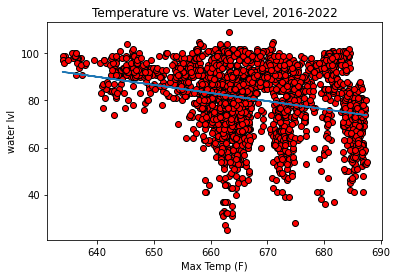

In [34]:
Scatter_temp = J17_Well_Final_Data["WaterLevelElevation"]
Scatter_water = Weather_Data_Temp_df["Temp Max"]
plt.scatter(Scatter_temp, Scatter_water, marker="o", facecolors="red", edgecolors="black")
plt.plot(Scatter_temp, we_fit)
plt.title("Temperature vs. Water Level, 2016-2022")
plt.xlabel("Max Temp (F)")
plt.ylabel("water lvl")

In [53]:
pr_slope, pr_int, pr_r, pr_p, pr_std_err = stats.linregress(J17_Well_Final_Data["WaterLevelElevation"], Weather_Data_Precip["Precipitation"])

In [54]:
pr_fit = pr_slope * J17_Well_Final_Data["WaterLevelElevation"] + pr_int

print("R value:", pr_slope)

R value: nan


Text(0, 0.5, 'precipitation inches')

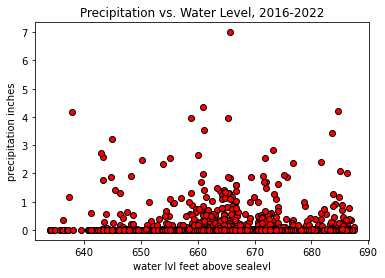

In [55]:
Scatter_precip = Weather_Data_Precip["Precipitation"]
Scatter_water = J17_Well_Final_Data["WaterLevelElevation"]
plt.scatter(Scatter_water, Scatter_precip, marker="o", facecolors="red", edgecolors="black")
plt.plot(Scatter_precip, pr_fit)
plt.title("Precipitation vs. Water Level, 2016-2022")
plt.xlabel("water lvl feet above sealevl")
plt.ylabel("precipitation inches")

In [63]:
#filtering so the population size are the same for 2016 vs 2022
J17_201622_df = J17_Well_Data_df.loc[(J17_Well_Data_df["DailyHighDate"] >= "2016-01-01") & (J17_Well_Data_df["DailyHighDate"] <= "2016-07-05")]
print("avg water lvl for 2016 01-01 to 07-05:", J17_201622_df["WaterLevelElevation"].mean())
print("avg water lvl for 2022 01-01 to 07-05:", J17_2022_df["WaterLevelElevation"].mean())

avg water lvl for 2016 01-01 to 07-05: 669.4779679144385
avg water lvl for 2022 01-01 to 07-05: 652.1637634408605


In [64]:
#alt, hypo the water levels have decreased 
#null, the water levels have remained the same or increased
#small p value reject the null 
stats.ttest_ind(J17_2022_df["WaterLevelElevation"], J17_201622_df["WaterLevelElevation"], equal_var=False)

Ttest_indResult(statistic=-19.542881965621348, pvalue=1.0264031561351222e-56)

In [66]:
print("avg waterlvl for 2022 up to 07-05: ", J17_2022_df["WaterLevelElevation"].mean(), 
      "\navg waterlvl for 2021: ", J17_2021_df["WaterLevelElevation"].mean(), 
      "\navg waterlvl for 2020: ", J17_2020_df["WaterLevelElevation"].mean(), 
      "\navg waterlvl for 2019: ", J17_2019_df["WaterLevelElevation"].mean(),
      "\navg waterlvl for 2018: ", J17_2018_df["WaterLevelElevation"].mean(), 
      "\navg waterlvl for 2017: ", J17_2017_df["WaterLevelElevation"].mean(),
      "\navg waterlvl for 2016: ", J17_2016_df["WaterLevelElevation"].mean())

avg waterlvl for 2022 up to 07-05:  652.1637634408605 
avg waterlvl for 2021:  662.8406301369863 
avg waterlvl for 2020:  664.5360382513666 
avg waterlvl for 2019:  677.2279452054793 
avg waterlvl for 2018:  664.2587945205479 
avg waterlvl for 2017:  670.4739178082191 
avg waterlvl for 2016:  675.1549999999999


In [69]:
#alt, all the means are different
#null, all means are equal
#reject the null, we have a small p value and a large f value
F, p = stats.f_oneway(J17_2022_df["WaterLevelElevation"], J17_2021_df["WaterLevelElevation"], 
               J17_2020_df["WaterLevelElevation"], J17_2019_df["WaterLevelElevation"], 
               J17_2018_df["WaterLevelElevation"], J17_2017_df["WaterLevelElevation"], 
               J17_2016_df["WaterLevelElevation"])

print("F value: ", F, "\np vlaue: ", p)

F value:  217.7127353769225 
p vlaue:  3.6716275023673637e-218


In [ ]:
# begin pct change work
# Converting specific column to Series
series = J17_Well_Data_df.iloc[:,2]

#print("\nSpecific column as a Series:\n")
#print(series)
#now we have pct change, how do we plot it?
pct_series=series.pct_change()

In [ ]:
#noting percent change between each row in the dataset
p = pct_series.plot(kind='line', color='r', alpha=0.5)
plt.axhline(y=0.000, color='b', linestyle='-')
#if you squint really hard at the 0 point and at the 2000 point you can see the drops later in the line
#are more drastic than those at the beginning of the line

In [ ]:
#When we look at just the precipitation binned into years, we can see a small dip in precipitation level in 2020
#NOT a definitive answer to where all the water went

rain_short = Weather_Data_df[['Date', 'Precipitation']].copy()
rain_short['year'] = pd.DatetimeIndex(rain_short['Date']).year

year = rain_short["year"]
precipitation = rain_short['Precipitation']
plt.scatter(year,precipitation)
plt.xticks(year, rotation=90)
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.show()

In [ ]:
#After we have cleaned data we will do the 10- day bucket sort to compare water days restrictons(SAWS uses a 10 day)

#we are looking for the date and a "drought level" (D01, D02, D03, D04) we will use both J17_well_Data_df and Drought_Data_df

#use .loc 

In [ ]:
#based on new data, start analyzing if the following day had higher vs lower vs equal compared to the restriction day.
#It will be a For loop thru previous cell using the +1



#Final data will be used to creat plots

In [ ]:
#
#Plot a bar chart using Temperature vs Water level to show correlation
#explorepossible analysis

In [ ]:
#
#Plot a bar chart using Humidity vs Water level to show correlation
#explorepossible analysis

In [ ]:
#
#Plot a bar chart using Percipitation vs Water level to show correlation
#explorepossible analysis